<a href="https://colab.research.google.com/github/lutherkhill/codemash2020/blob/master/codemash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Civic Developers Quest to Change Healthcare**


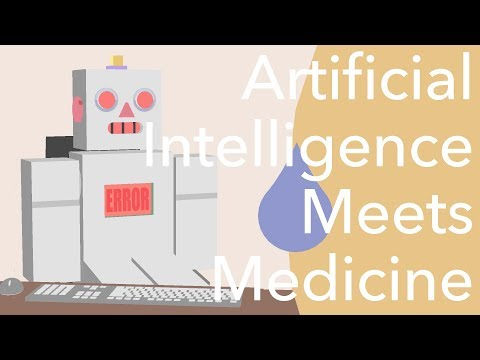

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZIiYbMVs7-8')

##Description and problem statement

For this application we used PyTorch and FastAi libary to design our model. We got our data from Kaggle using the Chest X-ray datset from the National Insitutue of Health (NIH). We used Jupyter notebooks that was hosted in the cloud using Google Colab to build and deploy our model. the Google Colab infrastructure allows us to leverage free resources like Graphical Processing Units (GPU) and SSD hard drives. 

To train our 

##Goals for talk

. More specifically, model performance is measured by the
AUC scores over 5 diseases: Atelectasis, Cardiomegaly, Consolidation, Edema, and Pleural Effusion

Atelectasis', 'Infiltration'

# **The dataset**

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# load fastai dependencies
import fastai
from fastai.vision import *
from fastai.metrics import *

# Imports for diverse utilities
import torchvision.models as models
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern
from sklearn.metrics import roc_auc_score, recall_score

#conect to google drive to easier storeage and redundency
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
# build way to measure auroc[what is auroc?]
def auroc_score(input_, target):
    input_, target = input_.cpu().numpy(), target.cpu().numpy() #.reshape(-1, learn.data.c)
    score = []
    for i in range(14):
        try: 
            score.append(roc_auc_score(target[:,i], input_[:,i]))
        except ValueError:
            score.append(0)
    
    return np.array(score).mean()

#     def __init__(self):
#         pass

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = auroc_score(output, target)
            return add_metrics(last_metrics, metric)

In [12]:
from IPython.display import IFrame
IFrame('https://blog.revolutionanalytics.com/2016/11/calculating-auc.html',
       width='100%', height=500)

## Get the data
The NIH dataset is freely availble on kaggle. For this exercise we will be using a smaple set o the data. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add source activate fastai or similar, or prefix pip with a path. Have a look at how conda install is called for your platform in the appropriate Returning to work section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# install the kaggle command line tool
# ! {sys.executable} -m pip install kaggle --upgrade

You're all set to download the data from planet competition. You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).

In [0]:
# this will download the dataset right into your gdrive and unzip the file
# !kaggle datasets download -d nih-chest-xrays/sample
# !unzip -q sample.zip

## Corelation between labels

Atelectasis
Consolidation
Infiltration
Pneumothorax
Edema
Emphysema
Fibrosis
Effusion
Pneumonia
Pleural_thickening
Cardiomegaly
Nodule Mass
Hernia


## Preprocess the data for learning



In [0]:
# set path to data
path = "/gdrive/My Drive/heart_disease/sample/images"

# set path for data labels
df_label_nih = pd.read_csv(path+'/label_nih.csv')

In [6]:
#number of images
img_files = os.listdir(path)
img_files[:5], len(img_files)

(['00027168_001.png',
  '00027236_000.png',
  '00027110_000.png',
  '00027213_086.png',
  '00027089_001.png'],
 5611)

In [0]:
# we are going to take a look at the first 5 and the last 5 rows
df_label_nih.head(-1)

In [0]:
df_label_nih.describe()

In [0]:
# construct the the data source
#convert to black and white
#convert_mode='L'
np.random.seed(42)
src = (ImageList.from_csv(path, 'label_nih.csv').split_by_rand_pct(0.2).label_from_df(label_delim='|', cols='labels'))

In [0]:
# sets the transformation for the dat to crop out unused parts of the image
#tfms = zoom_crop(scale=0.75, do_rand=False)
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_rotate=5,
                      max_zoom=1.03,
                      max_lighting=0.03,
                      max_warp=0.03,
                      p_affine=0.05,
                      p_lighting=0.05,
                      )

In [0]:
#construct data bunch (need to add weight decay and drop out rate to improve accuracy)
data = (src.transform(size=512)
        .databunch(bs=18).normalize(imagenet_stats))

In [0]:
# data bunch information
data

In [0]:
# show the number of classes that your data has
data.c

In [17]:
# list the names of you data classes
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [0]:
#display data bunch
# size/quality of the image matters greatly from medical imaging analysis
data.show_batch(rows=1, figsize=(12,9))

#**The model**
Our base architecture is `resnet50` again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of accuracy. We determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

> Indented block



### Single Model

In [15]:
# create convolutional neural network and return the accuracy metric
# area under the curve  callback_fns=AUROC
# convert to 16bit
#.to_fp16()
learn = cnn_learner(data, models.resnet50, metrics=[AUROC(), fbeta]).to_fp32()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 343MB/s]


In [0]:
# show architecture
learn.model

In [0]:
# show model summary
learn.summary()

We use the LR Finder to pick a good learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


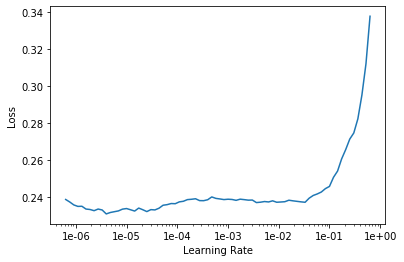

In [14]:
 # find the ideal inital learning rate for your model
GoogleNet_learner.lr_find()
GoogleNet_learner.recorder.plot()

In [0]:
# to pic the ideal learning rate we find the stepest part of the curve and back it up by a factor of ten.
#GoogleNet_learner.fit_one_cycle(1, slice(1e-01, 1e-02))

### Ensemble Model

In [0]:
# I want to train three different models and let them work in an ensemble together.
#First let's define the function for training with the architecture as input parameters. 
#I selected a batch size of 32 and applied data augmentation to it.
#train_path = path
#number_epochs=5
#slices = slice(1e-01,1e-02) #

def train(arch, number_epochs, slices):
    
    #construct data bunch (need to add weight decay and drop out rate to improve accuracy)
    data = (src.transform(size=512).databunch(bs=32).normalize(imagenet_stats))

    #define learner
    learn = cnn_learner(data, arch, metrics=[AUROC(), fbeta]).to_fp32()

    #train
    learn.fit_one_cycle(number_epochs, slices)
    
    return learn

In [0]:
#Lets train the three different model architectures: Resnet50, densenet121 and vgg19_bn
# GoogleNet_learner = train(models.googlenet, 1, slice(1e-01, 1e-02))
# DenseNet_learner = train(models.densenet201, 1, slice(1e-01, 1e-02))
# ResNext_learner = train(models.resnext101_32x8d, 1, slice(1e-01, 1e-02))
# SqueezeNet_learner = train(models.squeezenet1_1, 1, slice(1e-01, 1e-02))
# VGG_learner = train(models.vgg19_bn, 1, slice(1e-01, 1e-02))
# WideResnet_learner = train(models.wide_resnet101_2, 1, slice(1e-01, 1e-02))
# MnasNet_learner = train(models.mnasnet1_3, 1, slice(1e-01, 1e-02))
# Inception_learner = train(models.inception_v3, 1, slice(1e-01, 1e-02))
# ShuffleNet_learner = train(models.shufflenet_v2_x2_0, 1, slice(1e-01, 1e-02))
# AlexNet_learner = train(models.alexnet, 1, slice(1e-01, 1e-02))

In [0]:
GoogleNet_learner = train(models.googlenet, 10, slice(1e-05, 1e-06))


In [0]:
#Build ensemble
#Build an ensemble and use it for prediction

result_csv = 'submission.csv'
test_path = '../input/test/test/'

def ensemble_predition(test_img):
    img = open_image(test_img)

    
    #resnet_pred = resnet_learner.predict(img)
    #alexnet_pred = alexnet_learner.predict(img)
    GoogleNet_prediction = GoogleNet_learner.predict(img)
    DenseNet_prediction = DenseNet_learner.predict(img)
    ResNext_prediction = ResNext_learner.predict(img)
    # SqueezeNet_prediction = SqueezeNet_learner.predict(img)
    VGG_prediction = VGG_learner.predict(img)
    WideResnet_prediction = WideResnet_learner.predict(img)
    Inception_prediction = Inception_learner.predict(img)
    # ShuffleNet_prediction = ShuffleNet_learner.predict(img)
    # AlexNet_prediction = AlexNet_learner.predict(img)
    
    #ensemble average
    # sum_pred = resnet_pred[2]+alexnet_pred[2]
    # prediction = sum_pred/2
    sum_pred = GoogleNet_prediction[2]+DenseNet_prediction[2]+ResNext_prediction[2]+\VGG_prediction[2]+WideResnet_prediction[2]+Inception_prediction[2]
    prediction = sum_pred / 6
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    
    return predicted_label

In [23]:
test_img = path+'/test.jpg'

ensemble_predition(test_img)

4

In [22]:
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [0]:
#to give np array the correct style
submission_data = np.array([['dummy', 0]])

#progress bar
with tqdm(total=len(os.listdir(path))) as pbar:       
    #test all test images
    for img in os.listdir(path):
        label = ensemble_predition(img)
        new_np_array = np.array([[img, label]])
        submission_data = np.concatenate((submission_data, new_np_array), axis=0)
        pbar.update(1)

#remove dummy
submission_data = np.delete(submission_data, 0, 0)

#save final submission
result_df = pd.DataFrame(submission_data, columns=['img','Diagnosis'])
result_df.to_csv(result_csv, index=False)

## Metrics

In [0]:
# we will start taking a look a the metrics
learn.recorder.plot_metrics()

In [26]:
#Look at your 9 worst results. By using a heatmap to see what induced the wrong classification:
interp = ClassificationInterpretation.from_learner(resnet_learner, alexnet_learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

In [0]:
#plot top losses
interp.plot_multi_top_losses(9, figsize=(20,11))

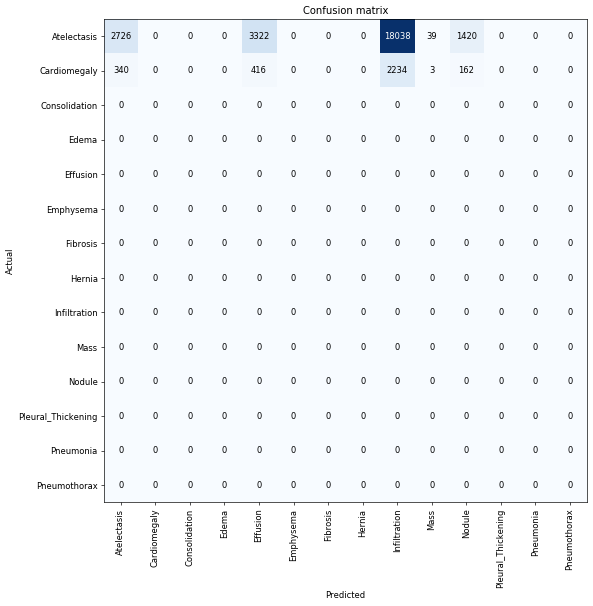

In [28]:
#confusion matrices that show you in a better way how good the CNN has performed
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [0]:
# display heatmap
# Thanks to https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_cam(learn, idx)

In [29]:
interp.most_confused(min_val=2)

[('Atelectasis', 'Infiltration', 18038),
 ('Atelectasis', 'Effusion', 3322),
 ('Cardiomegaly', 'Infiltration', 2234),
 ('Atelectasis', 'Nodule', 1420),
 ('Cardiomegaly', 'Effusion', 416),
 ('Cardiomegaly', 'Atelectasis', 340),
 ('Cardiomegaly', 'Nodule', 162),
 ('Atelectasis', 'Mass', 39),
 ('Cardiomegaly', 'Mass', 3)]

In [0]:
#unfreeze previous model to continue improving the model
learn.unfreeze()

In [0]:
# save the initial model
learn.save('codemash-1-resnet50-16bit')

In [0]:
# save the initial model
learn.save('name-iteration_num-architecture-flags')

In [0]:
# EXPORT MODEL
learner.export('name-iteration_num-architecture-flags'')

## Test the Finished Model

In [30]:
val_preds = model.get_preds(ds_type=DatasetType.Valid)[0].cpu().numpy()
val_true = df_labels.query('subset=="valid"')[model.data.classes].values

NameError: ignored

In [0]:
roc_auc_score(val_true, val_preds)

0.7834816540711038

In [0]:
auc_test_classes = {model.data.classes[i]: round(roc_auc_score(val_true[:, i], 
                                                         val_preds[:, i])*100, 2) 
              for i in range(14)}

results = pd.DataFrame(
            {
                'condition' : list(auc_test_classes.keys()),
                'auc' : [f'{i}%' for i in list(auc_test_classes.values())]
            }
        )[['condition', 'auc']]

results

,condition,auc
0,Atelectasis,78.41%
1,Cardiomegaly,87.67%
2,Consolidation,77.46%
3,Edema,88.21%
4,Effusion,85.61%
5,Emphysema,85.41%
6,Fibrosis,77.44%
7,Hernia,76.57%
8,Infiltration,70.55%
9,Mass,74.54%


In [0]:
# load model for inference / predictions
learn = load_learner("model path")

In [0]:
# load image and use it for prediction
img = learner.data.train_ds[0][0]
learner.predict(img)

## Diagnosing and fixing problems

I added this section because of the GPU memory management issues i kept running into with working with the notebook. The basic problems comes from limited memory capicity in most cloud services. Periodically you will have to free up memory to keep the training process going. this section will help you identify memory bottle necks and fix them.

In [1]:
# use to identify gpu mem usage
!/opt/bin/nvidia-smi
!nvcc --version

#identify processes using gpu memory
print("\nKill process with 'ipykernel_launcher'\n")
!ps -aux|grep python

Sun Dec  1 21:43:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# kill process with "ipkernel_launcher" to free gpu memory
!kill -9 1765

# **Deploy model on webapp**

- www.render.com
- www.github.com
